## In this notebook we create our model and evaluate it

**Model Steps:**

1. Run PCA on the preprocessed data

2. Use the elbow method to find a k value

3. Run kmeans with the dataframe created in the PCA step



# Set up and load data

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.cluster import KMeans, HDBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from umap import UMAP

RANDOM_STATE = 42

C:\Users\User\anaconda3\envs\music-recommender\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# if local
processed_users_path = "data/users_cleaned_encoded_df.parquet"

In [3]:
# # if google colab
# processed_users_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/users_cleaned_df_encoded.parquet"
# songs_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/songs_df_full.csv"
# from google.colab import drive
#
# drive.mount('/content/drive')

In [4]:
# Polars is faster at loading large datasets
users_polars_df = pl.read_parquet(processed_users_path)

In [5]:
users_df_orig = users_polars_df.to_pandas(use_pyarrow_extension_array=True)

In [6]:
len(users_df_orig)

292126

In [7]:
users_df = users_df_orig.copy().sample(
    n=50000,
    random_state=RANDOM_STATE
)

In [8]:
# Drop all one hot encoded fav artist columns (takes too long to run)
users_df = users_df[users_df.columns.drop(list(users_df.filter(regex='fav_artist_')))]
len(users_df)

50000

## Dimensional Reduction

### PCA for k-means
Run PCA and capture at least 90% of the variance.

In [9]:
# Want to keep at least 90% of the variance
transformer = PCA(n_components=0.9, random_state=RANDOM_STATE)

In [10]:
# Drop user_id as it will not have relevance for clustering
X = users_df.drop(columns=['user_id'])

In [11]:
X_pca = transformer.fit_transform(X)

In [12]:
# Create new columns for each of the components
num_cols = X_pca.shape[1]
X_pca_df = pd.DataFrame(
    X_pca,
    columns=[f'PC{i + 1}' for i in range(num_cols)]
)
X_pca_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.494177  1.903571 -0.902753  0.787106 -0.440064 -0.054883 -1.628275   
1  1.231804 -0.442377  1.084676  0.581548 -0.161600 -0.150417  0.153376   
2 -1.168970 -0.905932  0.173204 -0.625907 -0.200280 -0.547495  0.309504   
3 -2.162623 -1.261145 -0.149182  0.636774  0.014145 -0.476904  0.180959   
4 -1.286708 -1.296576 -0.817151 -0.107811 -0.272365  0.236439 -0.177397   

        PC8       PC9  
0 -0.109117  0.326894  
1 -0.044036  1.221112  
2  0.126936 -0.003711  
3 -0.408907 -0.695558  
4 -0.209463 -0.084016

In [13]:
print("Explained variance ratio by each component:", transformer.explained_variance_ratio_)
print("Total variance captured:", np.sum(transformer.explained_variance_ratio_))

Explained variance ratio by each component: [0.32609937 0.27343462 0.09386517 0.06619103 0.05954598 0.02678299
 0.02385928 0.02034301 0.01745328]
Total variance captured: 0.9075747338213543


### UMAP for HDBSCAN

In [14]:
# hdbscan = O(n^2) = takes too long to run on full dataset
X_hdbscan = users_df.drop(columns=['user_id'])

In [15]:
print("Starting UMAP for HDBSCAN...")
start_time = time.time()
# works better than pca for hdbscan
X_umap = UMAP(
    n_components=15,  # number of dimensions to reduce to
    n_neighbors=50,  # number of nearest neighbors to use in manifold approximation
    min_dist=0.0,  # how tightly packed the manifold is within the local neighborhood
).fit_transform(X_hdbscan)

end_time = time.time()
print(f"UMAP completed in {end_time - start_time:.2f} seconds")

Starting UMAP for HDBSCAN...
UMAP completed in 18.58 seconds


In [16]:
print("Shape:", X_umap.shape)
X_umap

Shape: (50000, 15)


array([[8.590822 , 8.124284 , 7.1151814, ..., 4.524423 , 5.2925396,
        4.606977 ],
       [9.557666 , 9.571741 , 5.3986626, ..., 3.8447642, 6.210831 ,
        5.957417 ],
       [9.914737 , 9.798566 , 5.9976177, ..., 3.8381338, 5.4787564,
        4.789715 ],
       ...,
       [9.482262 , 5.9628186, 4.864918 , ..., 4.685675 , 4.958053 ,
        4.789208 ],
       [8.192148 , 8.857908 , 5.350231 , ..., 4.309026 , 5.5629916,
        4.7129636],
       [9.623072 , 7.577289 , 3.8356414, ..., 3.6287794, 5.0259604,
        4.6608067]], shape=(50000, 15), dtype=float32)

# Model Creation & Evaluation

## Model 1: K Means

### Picking K: Elbow method
Use elbow method and a plot to see how many clusters we should use.

In [17]:
n_clusters = 30  # how many clusters to test
k_values = range(1, n_clusters + 1)
inertia_values = []
# store the number of data points within each cluster for every k tested
kmeans_comp_arr = np.zeros((n_clusters, n_clusters))

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto')
    kmeans_fitted = kmeans.fit(X_pca_df)
    inertia_values.append(kmeans.inertia_)
    # unique cluster labels assigned to each data point, counts points in cluster
    cluster_id, counts = np.unique(kmeans_fitted.labels_, return_counts=True)
    for i in range(len(cluster_id)):
        kmeans_comp_arr[k - 1, cluster_id[i]] = counts[i]

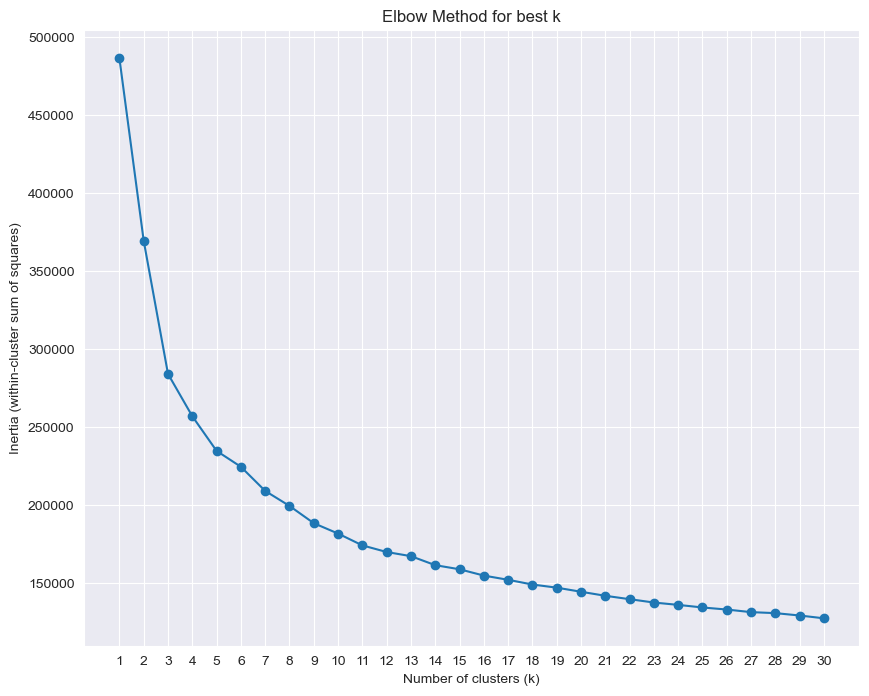

In [18]:
# Plot the elbow
plt.figure(figsize=(10, 8))
plt.plot(k_values, inertia_values, marker='o')
plt.xticks(k_values)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.title('Elbow Method for best k')
plt.grid(True)
plt.show()

In [19]:
kmeans_comp_df = pd.DataFrame(
    kmeans_comp_arr,
    index=k_values,
    columns=[f'Cluster {i}' for i in range(n_clusters)]
)

print("Distribution of data points per cluster for each k (rows = k, columns = cluster ID):")
display(kmeans_comp_df.head(10))

Distribution of data points per cluster for each k (rows = k, columns = cluster ID):


Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4  Cluster 5  \
1     50000.0        0.0        0.0        0.0        0.0        0.0   
2     38808.0    11192.0        0.0        0.0        0.0        0.0   
3     32865.0    10182.0     6953.0        0.0        0.0        0.0   
4     26315.0     4513.0     6018.0    13154.0        0.0        0.0   
5      9136.0     4163.0     1870.0    11213.0    23618.0        0.0   
6      8972.0     1558.0     1815.0    10729.0    23296.0     3630.0   
7      5090.0     1469.0     1661.0     9933.0    20562.0     3537.0   
8      4748.0     5850.0     1731.0     7625.0     9602.0     2056.0   
9      8317.0     5272.0     1535.0     6971.0     8433.0     1843.0   
10     3970.0     4339.0     1530.0     5780.0     8107.0     1681.0   

    Cluster 6  Cluster 7  Cluster 8  Cluster 9  ...  Cluster 20  Cluster 21  \
1         0.0        0.0        0.0        0.0  ...         0.0         0.0   
2         0.0        0.0        0.0        0.0  ...         0.0         0.0   
3         0.0        0.0        0.0        0.0  ...         0.0         0.0   
4         0.0        0.0        0.0        0.0  ...         0.0         0.0   
5         0.0        0.0        0.0        0.0  ...         0.0         0.0   
6         0.0        0.0        0.0        0.0  ...         0.0         0.0   
7      7748.0        0.0        0.0        0.0  ...         0.0         0.0   
8     17078.0     1310.0        0.0        0.0  ...         0.0         0.0   
9     12331.0     1299.0     3999.0        0.0  ...         0.0         0.0   
10    11828.0     1197.0     3447.0     8121.0  ...         0.0         0.0   

    Cluster 22  Cluster 23  Cluster 24  Cluster 25  Cluster 26  Cluster 27  \
1          0.0         0.0         0.0         0.0         0.0         0.0   
2          0.0         0.0         0.0         0.0         0.0         0.0   
3          0.0         0.0         0.0         0.0         0.0         0.0   
4          0.0         0.0         0.0         0.0         0.0         0.0   
5          0.0         0.0         0.0         0.0         0.0         0.0   
6          0.0         0.0         0.0         0.0         0.0         0.0   
7          0.0         0.0         0.0         0.0         0.0         0.0   
8          0.0         0.0         0.0         0.0         0.0         0.0   
9          0.0         0.0         0.0         0.0         0.0         0.0   
10         0.0         0.0         0.0         0.0         0.0         0.0   

    Cluster 28  Cluster 29  
1          0.0         0.0  
2          0.0         0.0  
3          0.0         0.0  
4          0.0         0.0  
5          0.0         0.0  
6          0.0         0.0  
7          0.0         0.0  
8          0.0         0.0  
9          0.0         0.0  
10         0.0         0.0  

[10 rows x 30 columns]

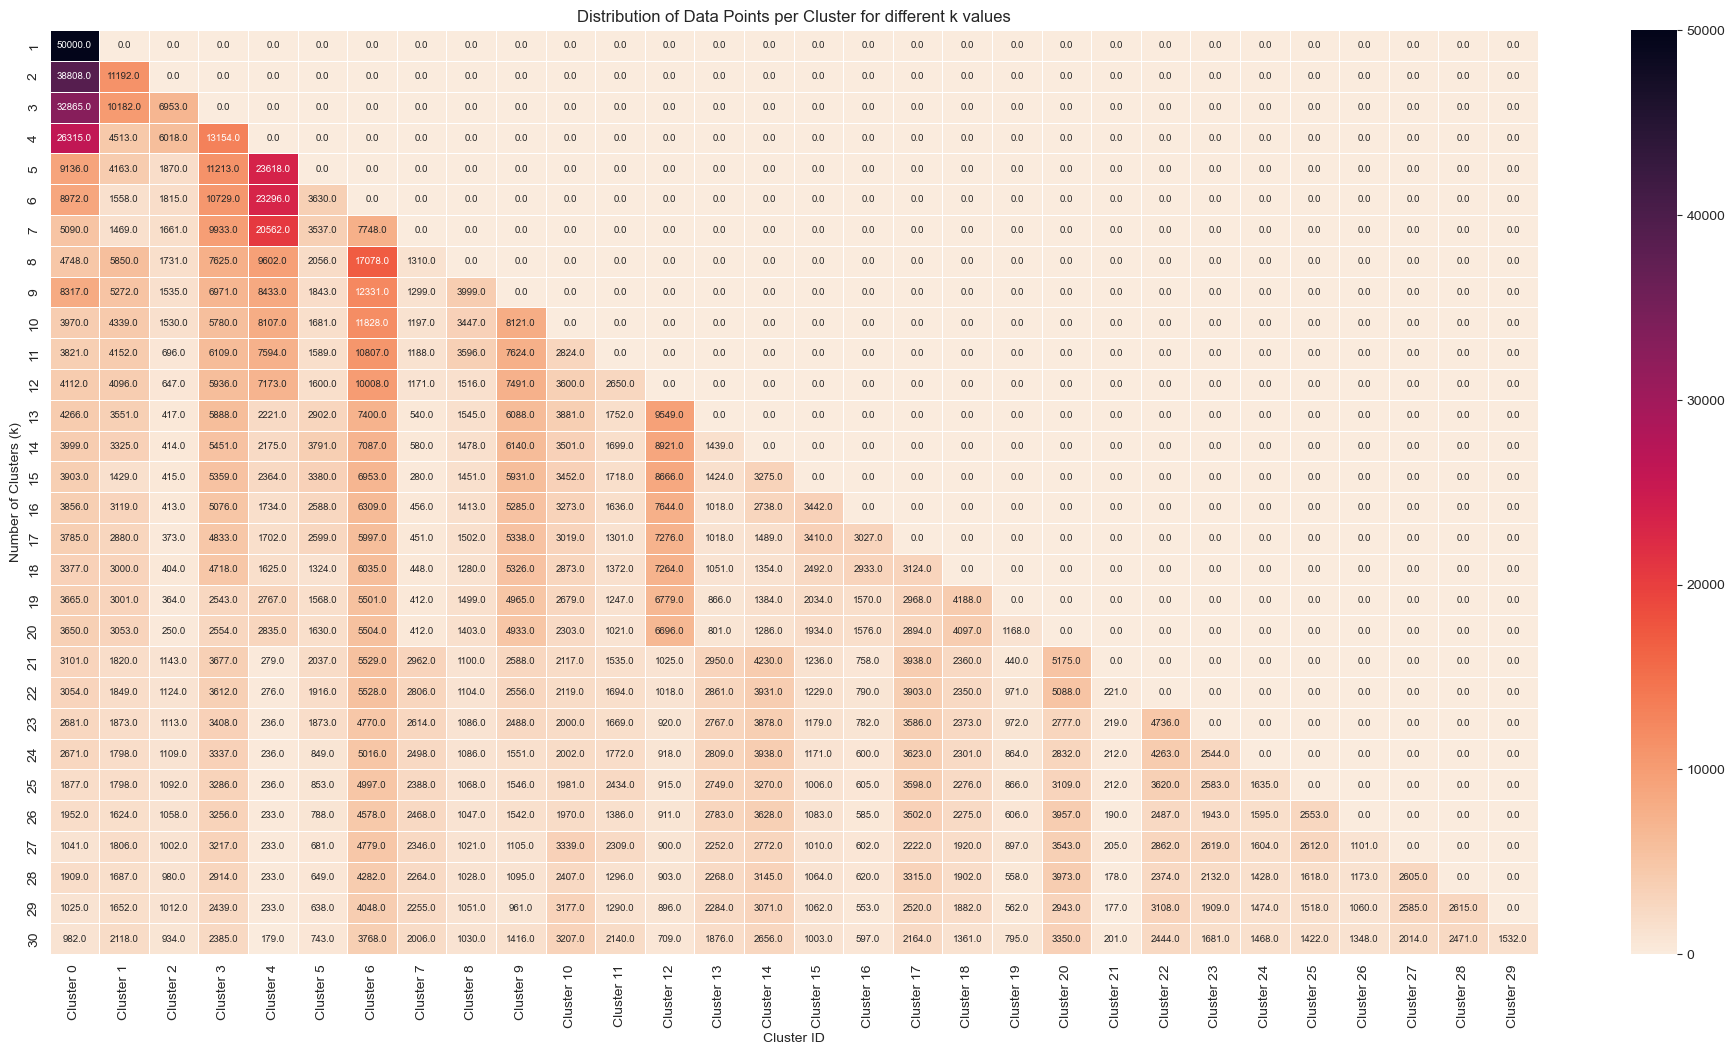

In [20]:
plt.figure(figsize=(24, 12))
sns.heatmap(kmeans_comp_df,
            annot=True,
            fmt='.1f',
            cmap='rocket_r',
            annot_kws={'fontsize': 7},
            linewidths=0.5
            )
plt.title('Distribution of Data Points per Cluster for different k values')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Clusters (k)')
plt.show()

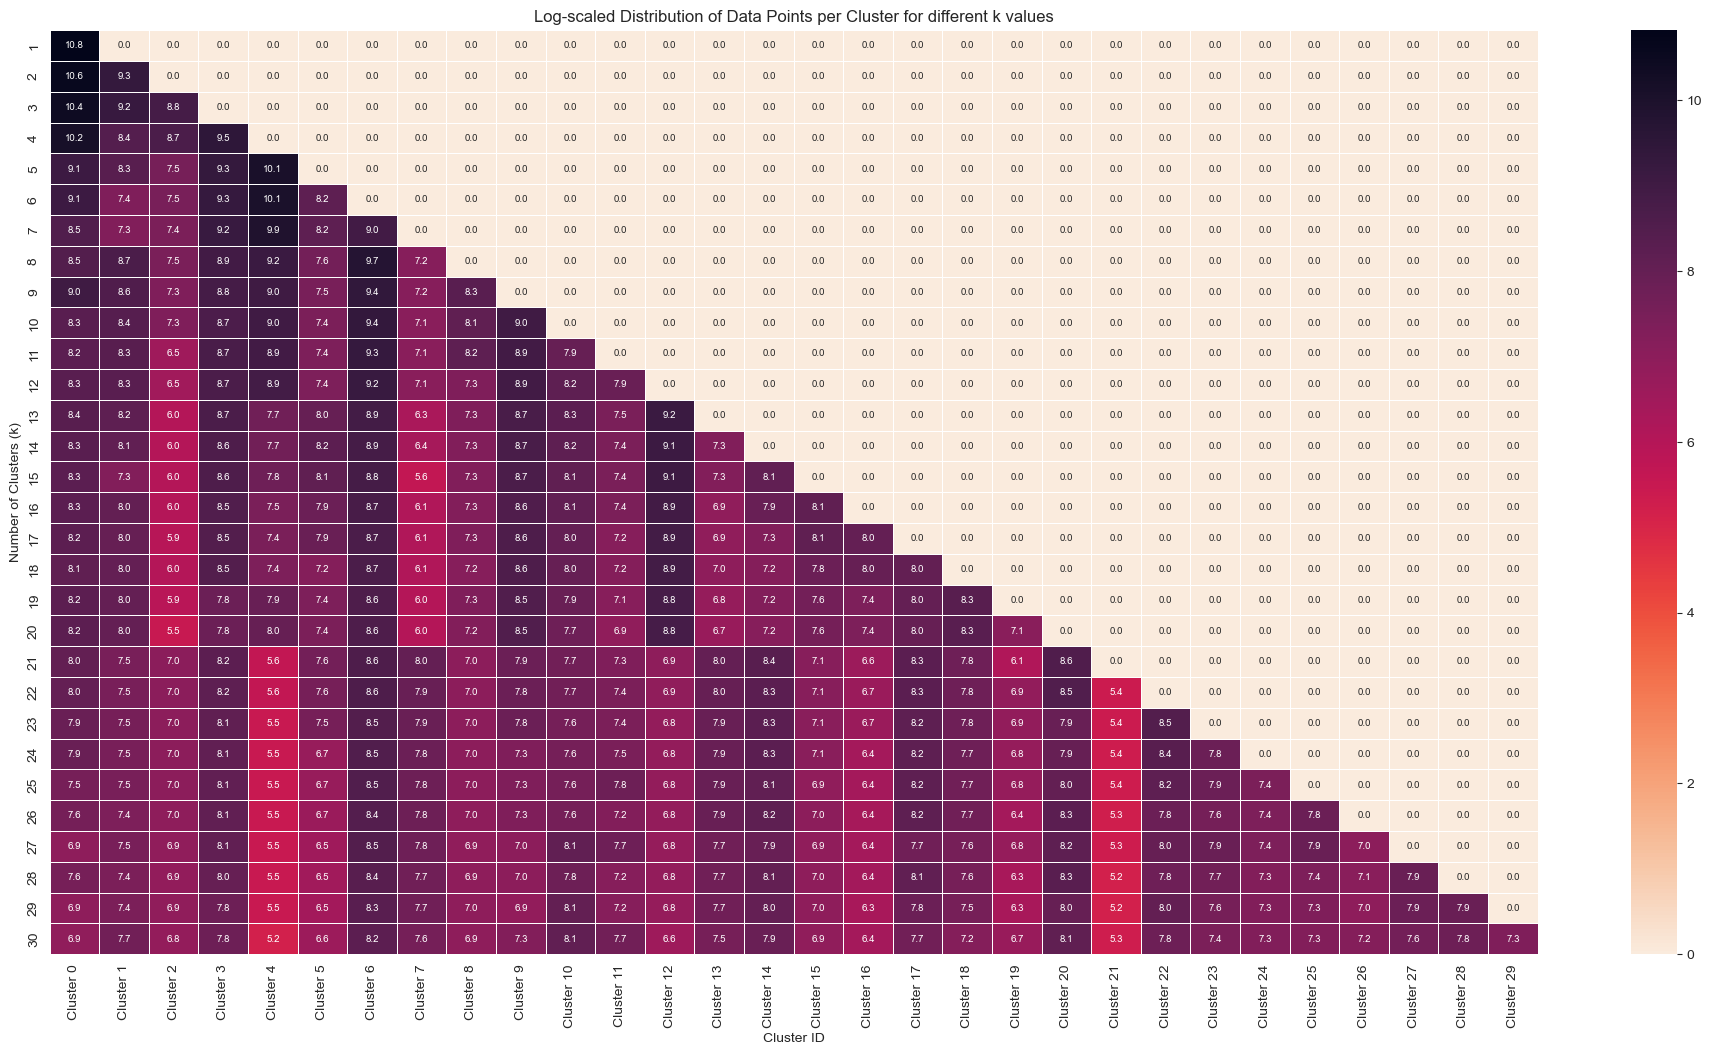

In [21]:
plt.figure(figsize=(24, 12))
sns.heatmap(np.log1p(kmeans_comp_df), annot=True, fmt='.1f', cmap='rocket_r', annot_kws={'fontsize': 7}, linewidths=0.5)
plt.title('Log-scaled Distribution of Data Points per Cluster for different k values')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Clusters (k)')
plt.show()

### Run k-means

In [22]:
# Based on the elbow, we observe a leveling out at k=9
k_num_clusters = 26

In [23]:
kmeans = KMeans(n_clusters=k_num_clusters, random_state=RANDOM_STATE, n_init='auto')
kmeans_fitted = kmeans.fit(X_pca_df)
inertia_values.append(kmeans.inertia_)
np.unique(kmeans_fitted.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int32),
 array([1952, 1624, 1058, 3256,  233,  788, 4578, 2468, 1047, 1542, 1970,
        1386,  911, 2783, 3628, 1083,  585, 3502, 2275,  606, 3957,  190,
        2487, 1943, 1595, 2553]))

### Evaluate k-means

In [24]:
users_clustered_df = users_df.copy()
users_clustered_df['kmeans_cluster'] = kmeans_fitted.labels_

In [25]:
# Compute Silhouette Score to measure cluster similarity
# It's costly to run, so we sample with 50k
sample = np.random.choice(len(X_pca_df), size=50000, replace=False)
score = silhouette_score(X_pca_df.iloc[sample], kmeans_fitted.labels_[sample])
print("Silhouette Score (sample):", score)

Silhouette Score (sample): 0.11356668195478327


In [26]:
# For PCA Plots
users_columns_pca = X_pca_df.columns
users_centroids_pca = kmeans_fitted.cluster_centers_
users_kmeans_centroids_df = pd.DataFrame(columns=users_columns_pca, data=users_centroids_pca)
users_kmeans_centroids_df['kmeans_cluster'] = users_kmeans_centroids_df.index

users_df_kmeans_clusters = X_pca_df.copy()
users_df_kmeans_clusters['kmeans_cluster'] = kmeans_fitted.labels_
users_df_kmeans_clusters['user_id'] = users_df['user_id']

In [27]:
users_kmeans_centroids_df.head(5)

PC1        PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.969019  -0.256275  2.262168  0.296572  0.074378 -0.004736 -0.042195   
1  2.185565   0.643800 -0.457513 -0.313277 -0.458719 -0.222477 -0.451597   
2  1.457206   2.925546 -0.169802  0.037861  0.010074 -0.022514 -0.083775   
3 -1.313691  -1.088943 -0.088606  0.513300  0.190345 -0.635601  0.094215   
4 -1.349387  10.331991 -0.487631 -0.011248  0.456518  0.546843  1.310603   

        PC8       PC9  kmeans_cluster  
0 -0.060425 -0.019394               0  
1 -0.156981  0.145243               1  
2  0.011433  0.110946               2  
3  0.134916 -0.346277               3  
4  0.665564 -0.771104               4

In [28]:
# For visualizing using original features
users_df_clusters_orig = users_df.copy()
users_df_clusters_orig['kmeans_cluster'] = kmeans_fitted.labels_
users_df_clusters_orig['user_id'] = users_df['user_id']

In [29]:
users_df_kmeans_clusters['kmeans_cluster'].value_counts().sort_index()

kmeans_cluster
0     1952
1     1624
2     1058
3     3256
4      233
5      788
6     4578
7     2468
8     1047
9     1542
10    1970
11    1386
12     911
13    2783
14    3628
15    1083
16     585
17    3502
18    2275
19     606
20    3957
21     190
22    2487
23    1943
24    1595
25    2553
Name: count, dtype: int64

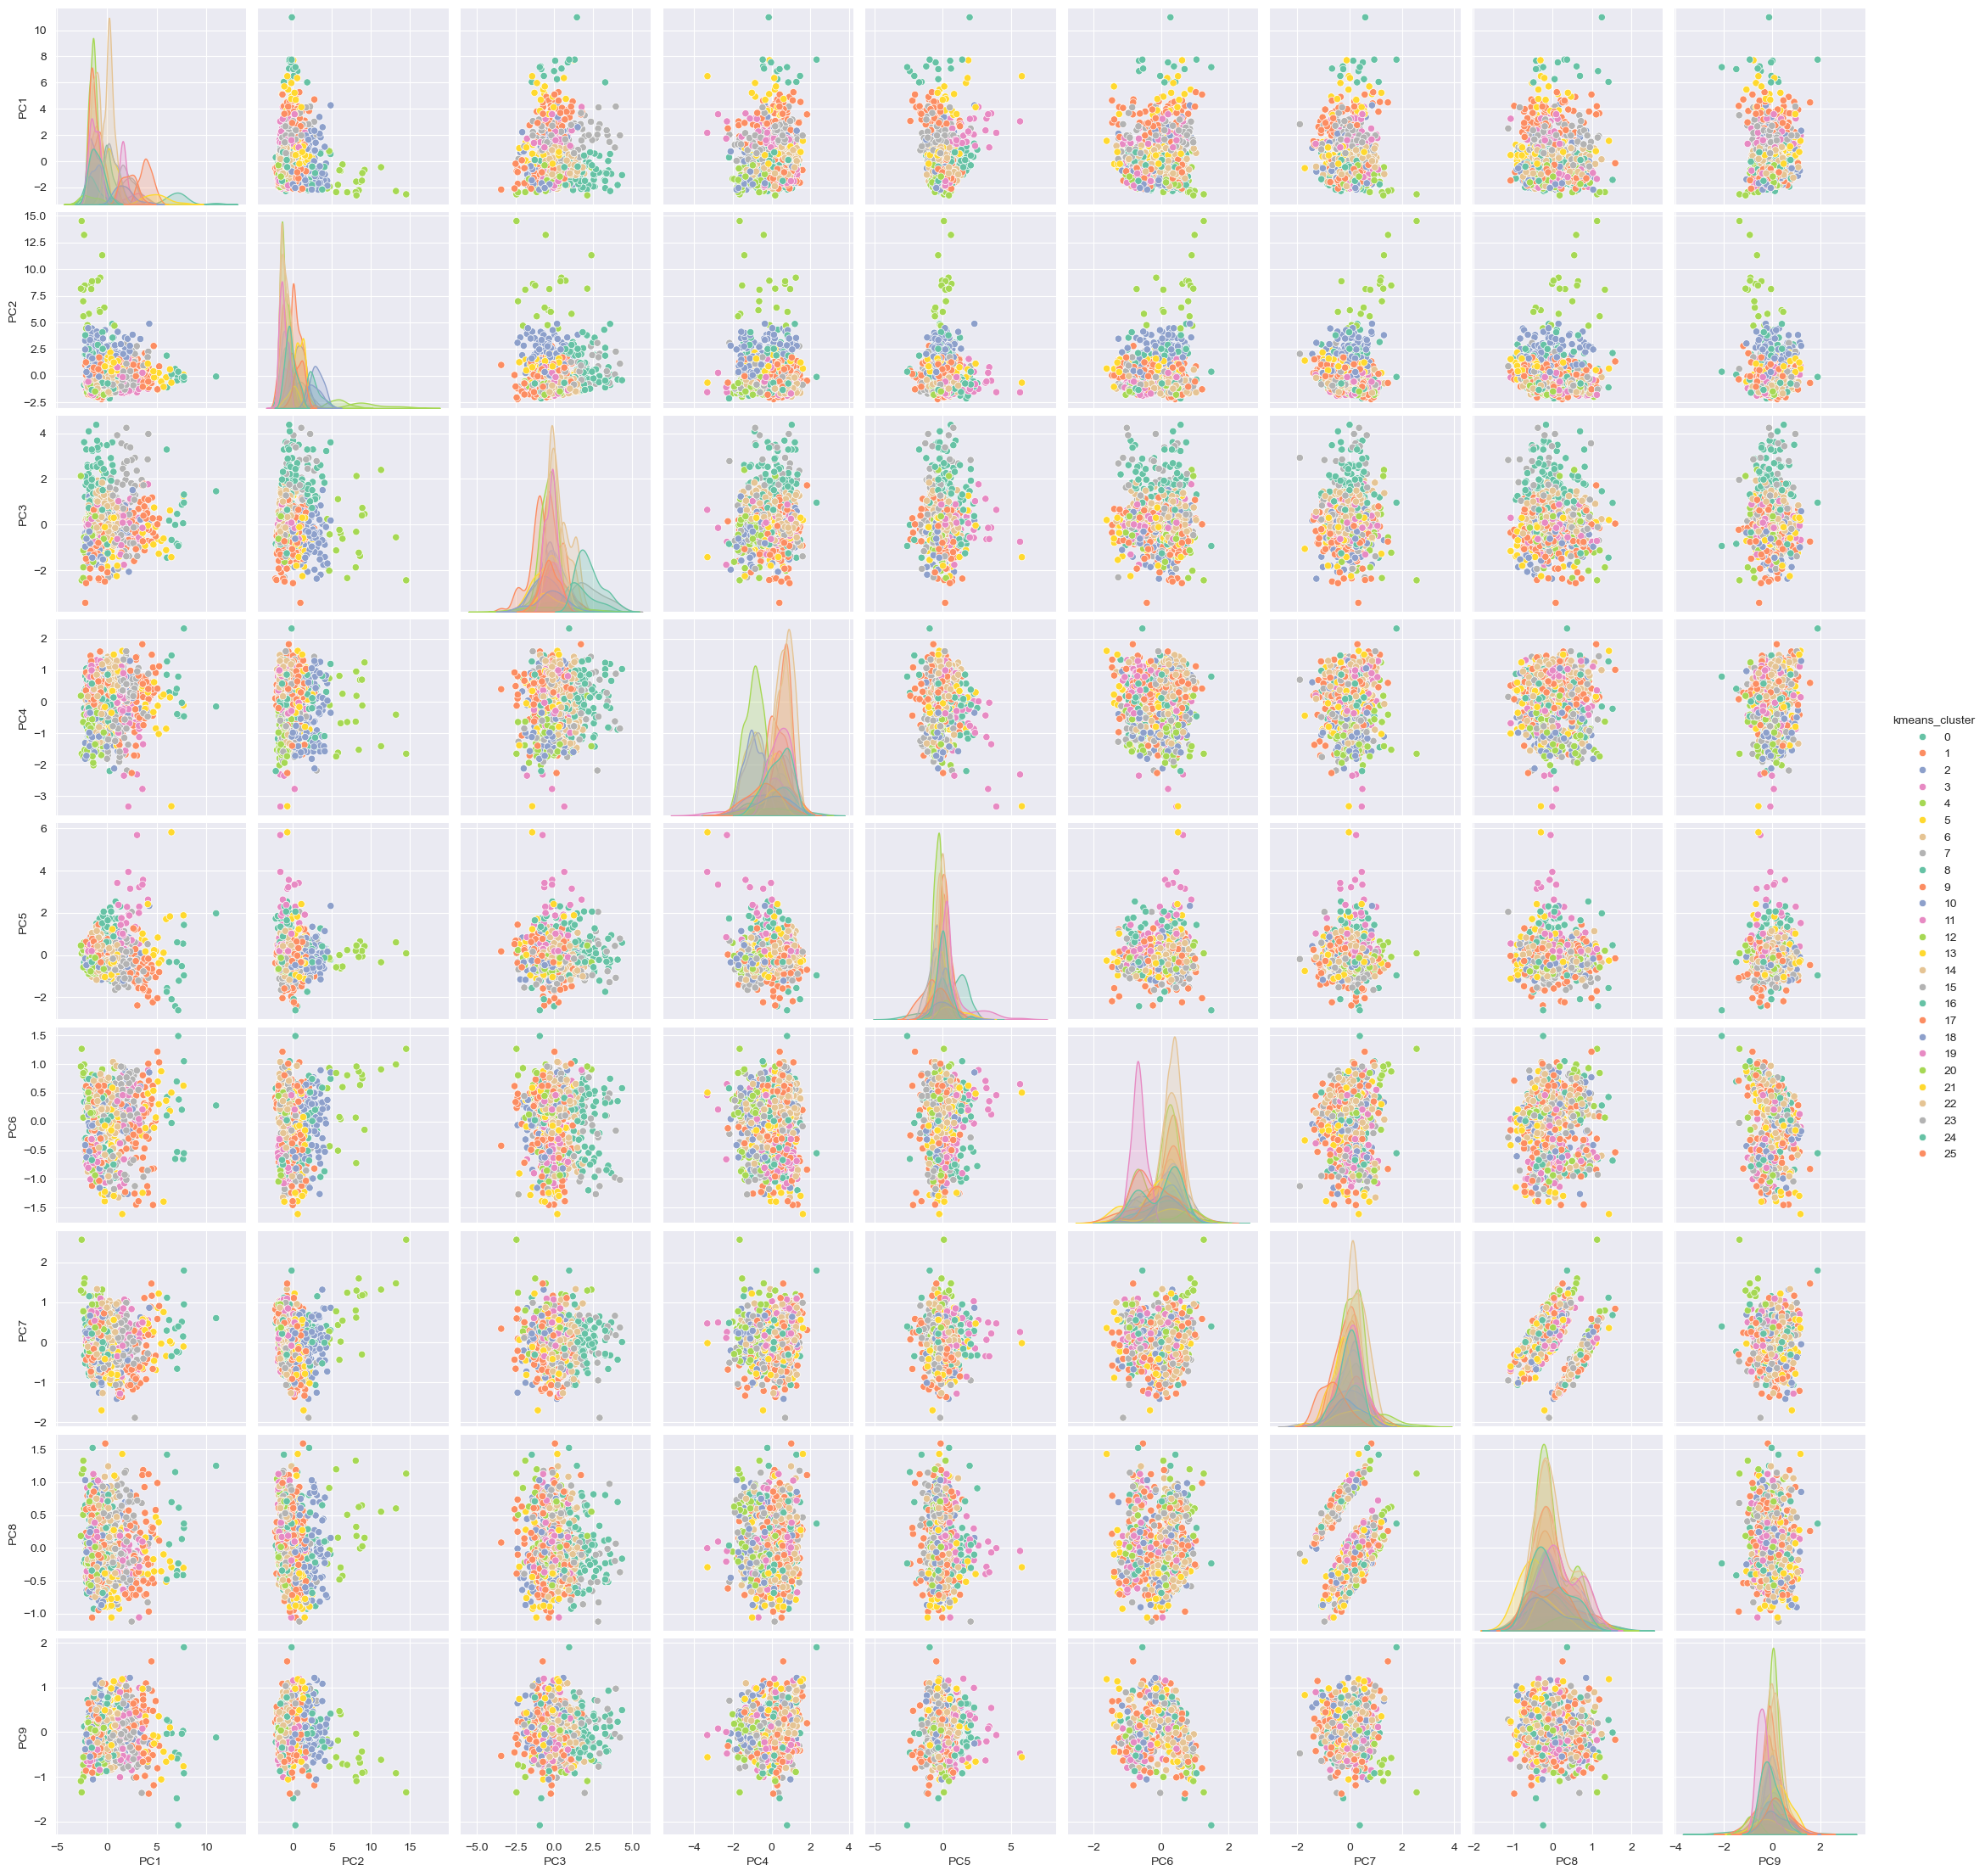

In [30]:
# How are clusters distinguished across different PC features?
sns.pairplot(
    hue='kmeans_cluster',
    palette='Set2',
    data=users_df_kmeans_clusters.sample(
        n=1000,
        random_state=RANDOM_STATE
    )
)

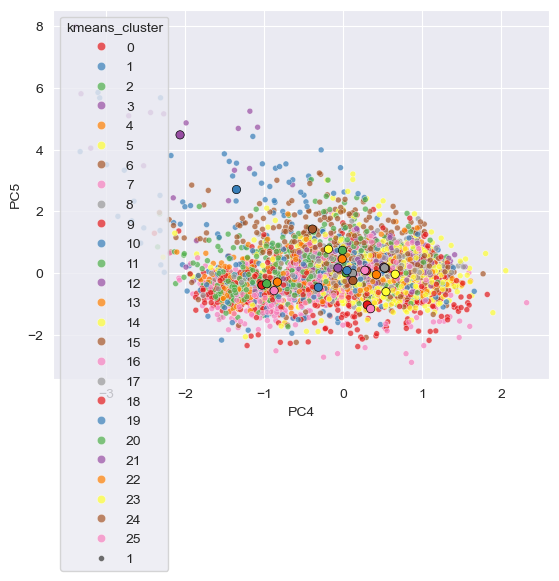

In [31]:
# Inspect a designated pc space more closely (look at pairplots for general overview)
# Also shows the centroids
variable_pairs = ['PC4', 'PC5']

# Plotting the results
sns.scatterplot(
    x=variable_pairs[0],
    y=variable_pairs[1],
    hue='kmeans_cluster',
    palette='Set1',
    size=1, alpha=0.7,
    data=users_df_kmeans_clusters.sample(
        n=5000,
        random_state=RANDOM_STATE
    )
)

sns.scatterplot(
    x=variable_pairs[0],
    y=variable_pairs[1],
    hue='kmeans_cluster',
    palette='Set1',
    markers=1000,
    alpha=1,
    edgecolor="black",
    data=users_kmeans_centroids_df,
    legend=False
)
plt.show()

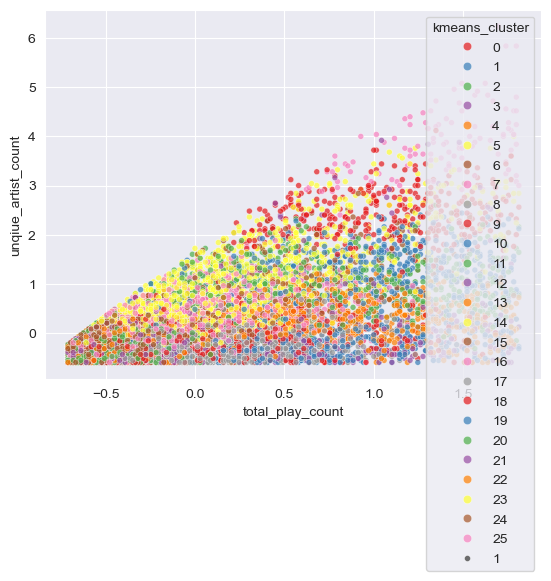

In [32]:
# To show that our current model is not separating just on play count and playtime
# We can see this because it is not neatly separated on these 2 features alone (like it was with just numerical values)
variable_pairs = ['total_play_count', 'unqiue_artist_count']
# Plotting the results
sns.scatterplot(
    x=variable_pairs[0],
    y=variable_pairs[1],
    hue='kmeans_cluster',
    palette='Set1',
    size=1, alpha=0.7,
    data=users_df_clusters_orig.sample(n=10000, random_state=RANDOM_STATE)
)
plt.show()

## Model 2: HDBSCAN
Density based clustering

*   We noticed in a previous milestone that we had clusters with very few data points, so we wanted to try density based clustering to remedy this.
*   DBSCAN groups points that are closely packed together (many nearby neighbors)
*   Outliers in low-desnity regions are marked



Faizan's Colab (CPU with High RAM)

n= 100000

- x_map time: 1 minute
- hdbscan time: 93 sec


n= 200000
- x_map time: 130 sec
- hdbscan time:  458.84 seconds


n= 300000
- x_map time: 209.01 seconds
- hdbscan time:  1081.89 seconds

### Run HDBSCAN

In [33]:
print("Starting HDBSCAN...")
start_time = time.time()

hdb_labels = HDBSCAN(
    min_cluster_size=200,  # of points in a group are valid to be a cluster, any less is noise
    min_samples=10,  # controls how strict "core" points are
    n_jobs=-1  # use all cores
).fit_predict(X_umap)

end_time = time.time()
print(f"HDBSCAN completed in {end_time - start_time:.2f} seconds")

Starting HDBSCAN...
HDBSCAN completed in 14.87 seconds


In [34]:
users_clustered_df["hdb_cluster"] = hdb_labels

In [35]:
num_hdb_clusters = len(users_clustered_df["hdb_cluster"].unique())
print(num_hdb_clusters, "clusters")
users_clustered_df["hdb_cluster"].value_counts()
# 35k "-1"  with min_cluster_size=20, min_samples=10
# 36k "-1"  with min_cluster_size=20, min_samples=5

23 clusters


hdb_cluster
 19    27580
 18     4155
-1      3997
 20     3831
 17     1548
 4      1303
 15     1191
 1       701
 13      662
 16      657
 0       549
 10      468
 8       457
 2       390
 9       352
 5       336
 11      331
 3       310
 14      297
 6       233
 21      223
 12      219
 7       210
Name: count, dtype: int64

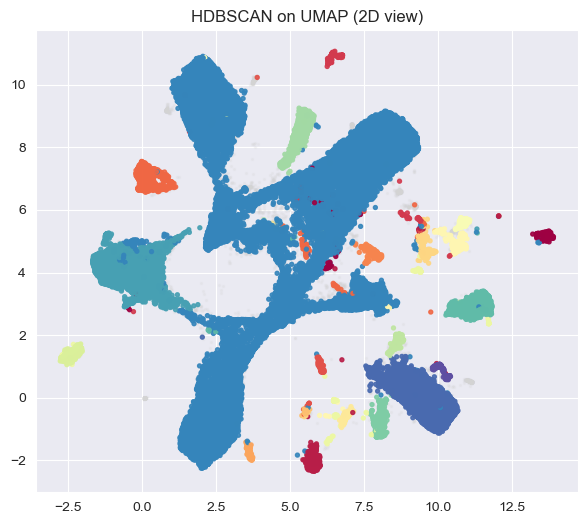

In [36]:
# Plot the clusters similar to how its done for PCA space in k-means
X_umap_2d = UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.0,
).fit_transform(X_hdbscan)
plot_df = pd.DataFrame(X_umap_2d, columns=["UMAP1", "UMAP2"])
plot_df["hdb_cluster"] = hdb_labels

noise = plot_df[plot_df["hdb_cluster"] == -1]
clusters = plot_df[plot_df["hdb_cluster"] != -1]

plt.figure(figsize=(7, 6))

# noise first, light gray
plt.scatter(
    noise["UMAP1"], noise["UMAP2"],
    c="lightgray", s=2, alpha=0.15
)

# clusters on top
plt.scatter(
    clusters["UMAP1"], clusters["UMAP2"],
    c=clusters["hdb_cluster"], cmap="Spectral",
    s=8, alpha=0.9
)

plt.title("HDBSCAN on UMAP (2D view)")
plt.show()

### Evaluate HDBSCAN

<Axes: xlabel='hdb_cluster', ylabel='Count'>

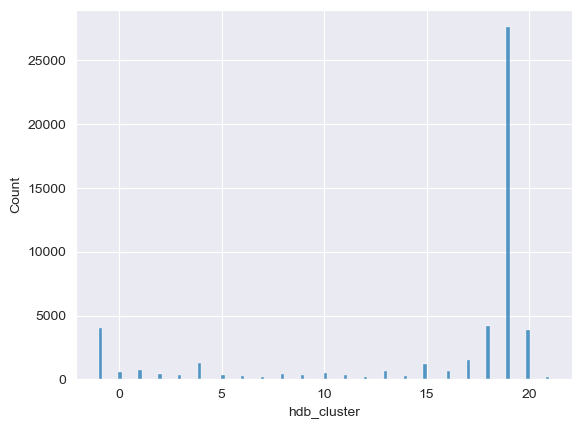

In [37]:
sns.histplot(users_clustered_df['hdb_cluster'])

In [38]:
# sns.pairplot(
#     hue='hdb_cluster',
#     palette='Set2',
#     data=users_clustered_df.sample(
#         n=1000,
#         random_state=RANDOM_STATE
#     )
# )

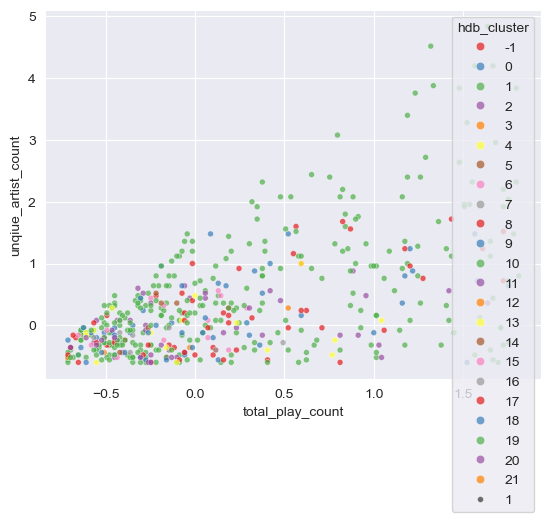

In [39]:
# To show that our current model is not separating just on play count and play time
# We can see this because it is not neatly separated on these 2 features alone (like it was with just numerical values)
variable_pairs = ['total_play_count', 'unqiue_artist_count']
# Plotting the results
sns.scatterplot(
    x=variable_pairs[0],
    y=variable_pairs[1],
    hue='hdb_cluster',
    palette='Set1',
    size=1, alpha=0.7,
    data=users_clustered_df.sample(n=500, random_state=RANDOM_STATE)
)
plt.show()

### Save Cluster Assignments

In [40]:
users_clustered_df.describe()

total_play_count  total_play_time  unqiue_artist_count  \
count           50000.0          50000.0              50000.0   
mean           0.158292         0.161472             0.293538   
std            0.659028         0.677122             0.890546   
min           -0.710145         -0.85254                 -0.6   
25%           -0.391304        -0.396577                -0.36   
50%                 0.0         0.000542                  0.0   
75%            0.594203         0.604087                 0.64   
max            1.811594         3.006549                 6.24   

       unqiue_song_count  fav_maj_count  fav_min_count  fav_year  year_count  \
count            50000.0        50000.0        50000.0   50000.0     50000.0   
mean            0.293538       0.298364        0.41433  -0.22622    0.227817   
std             0.890546       0.975122        1.01424  0.817851    0.783241   
min                 -0.6      -0.933333           -0.5      -2.0   -0.833333   
25%                -0.36      -0.333333          -0.25 -0.666667   -0.333333   
50%                  0.0            0.0            0.0       0.0         0.0   
75%                 0.64       0.666667           0.75  0.333333    0.666667   
max                 6.24            8.8           18.5       1.0         8.0   

       fav_song_plays  fav_song_duration  tot_fav_song_play_time  \
count         50000.0            50000.0                 50000.0   
mean         0.321676           0.137636                0.369295   
std          1.134428           0.985195                1.186155   
min              -0.8          -2.712173               -0.772187   
25%              -0.4          -0.459078               -0.353686   
50%               0.0          -0.003439                0.002874   
75%               0.6           0.530949                0.653672   
max              13.2           4.778886               15.742235   

       kmeans_cluster   hdb_cluster  
count     50000.00000  50000.000000  
mean         12.80936     15.470340  
std           7.46121      6.713519  
min           0.00000     -1.000000  
25%           6.00000     16.000000  
50%          13.00000     19.000000  
75%          20.00000     19.000000  
max          25.00000     21.000000

In [41]:
u_c_columns = ['user_id', 'hdb_cluster', 'kmeans_cluster']
users_clustered_df = users_clustered_df[u_c_columns]

In [42]:
users_clustered_df.head()

user_id  hdb_cluster  kmeans_cluster
137495  78bf27bfb5f2500eac6c8e1a002f34e70a7b7088           19              13
87200   4cc258e128a0f29a409c3496d92f691d6767ecd1            1              14
274057  f05994ca0b5de493704a7561451efeb4a6d6dfab            2              20
62122   36be68a207a0f581d3480cbe407938e4904f34a7           -1               3
103417  5af2527350515c63db37c88f9e71c76deb9819a9            1              25

In [43]:
# if local
users_clustered_path_parquet = "data/users_clusters_df.parquet"

In [44]:
# # if collab
# users_clustered_path_parquet = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/users_clusters_df.parquet"

In [45]:
# Save the processed dataframe to Parquet
users_clustered_df.to_parquet(users_clustered_path_parquet, index=False, engine='pyarrow')
print(f"Processed DataFrame saved to: {users_clustered_path_parquet}")

Processed DataFrame saved to: data/users_clusters_df.parquet
